In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
from os import mkdir
from os.path import join, exists
import os
import sys
import time
from datetime import datetime
from datetime import timedelta


In [2]:
class Cell3D:

    T_threshold = 273 + 50 # K # 50 deg C

    def __init__(self,name,gen_path):
        self.save_path = join(gen_path, name)
        if not exists(self.save_path):
            mkdir(self.save_path)        

    def define_cell_dimensions(self,lx,ly,lz):
        self.lx = lx
        self.ly = ly
        self.lz = lz
    
    def generate_grid(self,nx,ny,nz):
        self.nx = nx
        self.ny = ny
        self.nz = nz
        self.dx = self.lx/self.nx
        self.dy = self.ly/self.ny
        self.dz = self.lz/self.nz
    
    def define_cell_thermal_properties(self, T_init, kx, ky, kz, cp, q_gen, rho):
        self.T_init = T_init
        self.kx = kx
        self.ky = ky
        self.kz = kz
        self.cp = cp
        self.q_gen = q_gen
        self.rho = rho

    def define_heat_sink_properties(self,hx1,Tx_inf1, hy1,Ty_inf1, hz1, Tz_inf1,hx2,Tx_inf2, hy2,Ty_inf2, hz2, Tz_inf2):
        self.hx1, self.Tx_inf1 = hx1, Tx_inf1
        self.hy1, self.Ty_inf1 = hy1, Ty_inf1
        self.hz1, self.Tz_inf1 = hz1, Tz_inf1
        self.hx2, self.Tx_inf2 = hx2, Tx_inf2
        self.hy2, self.Ty_inf2 = hy2, Ty_inf2
        self.hz2, self.Tz_inf2 = hz2, Tz_inf2
    
    def define_timestep(self,dt,Nt):
        self.dt = dt
        self.Nt = round(Nt/dt)
    
    def perform_base_computations(self):
        self.number_of_cells = self.nx*self.ny*self.nz
        self.cell_volume = self.lx*self.ly*self.lz
        self.q_gen_per_volume = self.q_gen/self.cell_volume
        self.q_gen_cell = self.q_gen_per_volume/(self.rho*self.cp)

    def create_matrices(self):
        self.T = np.ones((self.nx, self.ny, self.nz))*self.T_init
        self.T_new = np.copy(self.T)
    
    def create_plot(self, step_time):        
        plot_title = ["Cell Center-section","Cell Body"]
        plot_data = [self.T[:, :,0],self.T[:, :,self.nz//2]]
        for data,title in zip(plot_data,plot_title):
            plt.clf()
            min_val = np.min(data)
            max_val = np.max(data)               
            plt.imshow(data, origin='lower', extent=[0, self.lx*1000, 0, self.ly*1000], cmap='jet', interpolation='bilinear',
                     vmin = min_val, vmax=max_val)                               
            cbar = plt.colorbar(label='Temperature (K)')
            cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.2f}'))  # Format colorbar to 2 decimal places
            plt.title('Temperature Distribution at '+str(step_time)+' seconds - '+ title)
            plt.xlabel('X position (mm)')
            plt.ylabel('Y position (mm)')
            filename = title+"_"+str(step_time)+".jpg" 
            save_path = join(self.save_path,filename)
            plt.savefig(save_path)             
    
    def create_graph(self):
        fig,ax = plt.subplots(figsize=(16,6))
        plt.plot(self.time, self.mean_T,label="Mean Temperature")
        plt.plot(self.time, self.max_T,label="Max Temperature")
        plt.plot(self.time, self.min_T,label="Min Temperature")
        plt.grid(True)
        plt.legend()
        save_path = join(self.save_path,"temperature_profile.jpg")
        plt.savefig(save_path)

    def simulate(self, timesteps):
        global T_threshold
        self.time = []
        self.mean_T = []
        self.max_T = []
        self.min_T = []
        for step in range(self.Nt):
            for i in range(self.nx):
                for j in range(self.ny):
                    for k in range(self.nz):
                        if i==0:
                            self.T_new[i,j,k] = self.T[i+1,j,k]+(self.hx1*self.dx/self.kx)*(self.Tx_inf1-self.T[i,j,k])
                        elif i==self.nx-1:
                            self.T_new[i,j,k] = self.T[i-1,j,k]+(self.hx2*self.dx/self.kx)*(self.Tx_inf2-self.T[i,j,k])
                        elif j==0:
                            self.T_new[i,j,k] = self.T[i,j+1,k]+(self.hy1*self.dy/self.ky)*(self.Ty_inf1-self.T[i,j,k])
                        elif j==self.ny-1:
                            self.T_new[i,j,k] = self.T[i,j-1,k]+(self.hy2*self.dy/self.ky)*(self.Ty_inf2-self.T[i,j,k])
                        elif k==0:
                            self.T_new[i,j,k] = self.T[i,j,k+1]+(self.hz1*self.dz/self.kz)*(self.Tz_inf1-self.T[i,j,k])
                        elif k==self.nz-1:
                            self.T_new[i,j,k] = self.T[i,j,k-1]+(self.hz2*self.dz/self.kz)*(self.Tz_inf2-self.T[i,j,k])
                        else:
                            d2Tdx2 = (self.T[i+1,j,k] - 2*self.T[i,j,k] + self.T[i-1,j,k])/self.dx**2
                            d2Tdy2 = (self.T[i,j+1,k] - 2*self.T[i,j,k] + self.T[i,j-1,k])/self.dy**2
                            d2Tdz2 = (self.T[i,j,k+1] - 2*self.T[i,j,k] + self.T[i,j,k-1])/self.dz**2
                            self.T_new[i,j,k] += self.dt*(self.q_gen_cell+(self.kx*d2Tdx2 + self.ky*d2Tdy2 + self.kz*d2Tdz2)/(self.rho*self.cp))
                            
            self.T = np.copy(self.T_new)         
            if (step*self.dt).is_integer():
                step_time = step*self.dt
                self.time.append(step_time)
                mean_temp = np.mean(self.T)
                max_temp = np.max(self.T)
                min_temp = np.min(self.T)
                self.mean_T.append(mean_temp)
                self.max_T.append(max_temp)
                self.min_T.append(min_temp)
                if step_time in timesteps:
                    self.create_plot(step_time)
                # Write stuff to output file
#                 fw = open("case_info.txt", "w+")
#                 fw.write(f"""
# Cell capacity          : {ah} Ah\n\
# Cell DCIR              : {dcir} Ohms\n\
# C_rate                 : {c_rate} C\n\
# T_max                  : {np.max(T)} K\n\
# Cell with T_max        : {i},{j},{k}\n\
# Time to reach T_max    : {current_time} s\n\
# Simulation run time    : {time_exec} s\n\
# """)             
#                 fw.close()
                if max_temp > self.T_threshold:
                    break

            

In [3]:
def main_func(ah, dcir, c_rate, gen_path):   
    case_title = f"{ah}Ah_{c_rate}C"
    print (f"Currently running: {case_title}")
    # Base calcs
    I = float(ah) * float(c_rate)
    q_gen = I * I * float(dcir)

    # BCs
    T_init  = 273 + 20 # K # 20 deg. C
    T_inf   = 273 + 25 # K # 25 deg. C
    h       = 2 # W/m2.K

    # gen_path = r"/home/kage-main/Documents/01_Codes/02_projects/Cell_SOC_Model/thermal_model/jpegs"
    cell = Cell3D(f"{case_title}", gen_path)
    cell.define_cell_dimensions(0.115, 0.105, 0.022)
    cell.generate_grid(20, 20, 10)
    cell.define_cell_thermal_properties(T_init, 36, 36, 1.3, 1200, q_gen, 2032)
    cell.define_heat_sink_properties(h, T_inf, h, T_inf, h, T_inf, h, T_inf, h, T_inf, h, T_inf)
    cell.define_timestep(0.025, (3600 / float(c_rate)) + 1)
    cell.perform_base_computations()
    cell.create_matrices()
    # timesteps = [0, 1, 10, 30, 60, 100, 240, 360]
    # timesteps = [range(0, int(3600 / float(c_rate)) + 1, 10)]
    timestamps = [timedelta(seconds=i) for i in range(0, 3601, 10)]
    cell.simulate(timesteps)
    cell.create_graph()

Currently running: 26Ah_1.0C
Currently running: 26Ah_4.0C
Currently running: 26Ah_4.5C
Currently running: 26Ah_5.0C
Currently running: 26Ah_5.5C
Currently running: 26Ah_6.0C
Currently running: 26Ah_6.5C
Currently running: 26Ah_7.0C
Currently running: 26Ah_7.5C
Currently running: 26Ah_8.0C
Currently running: 26Ah_8.5C
Currently running: 26Ah_9.0C
Currently running: 26Ah_9.5C
Currently running: 26Ah_10.0C


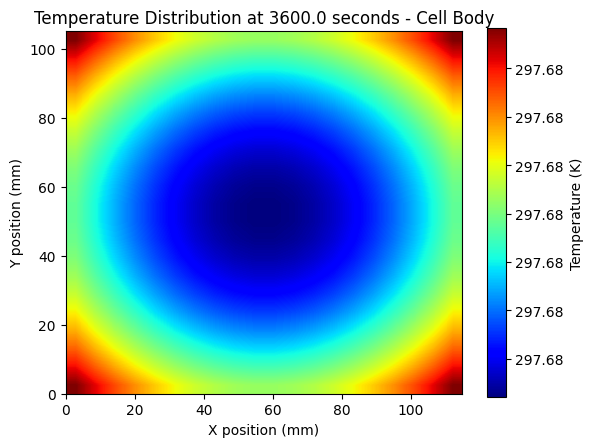

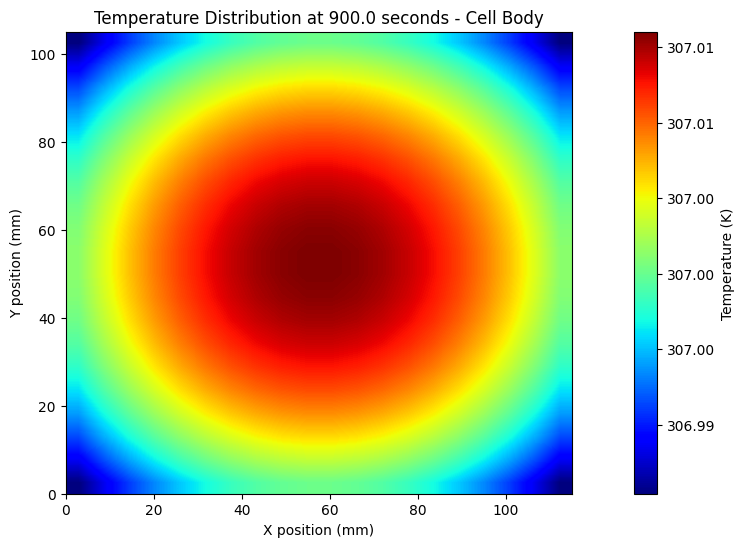

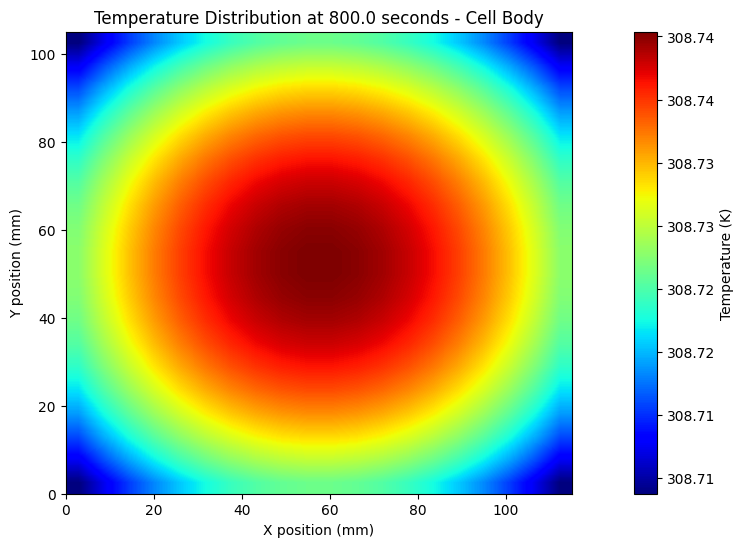

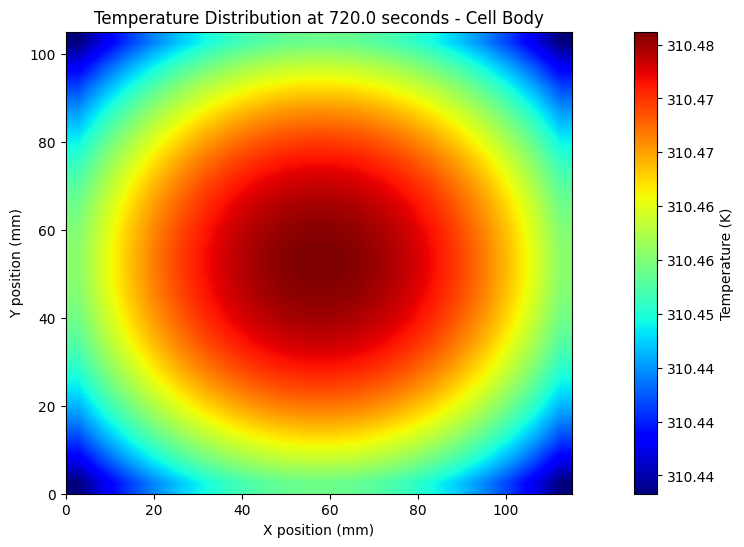

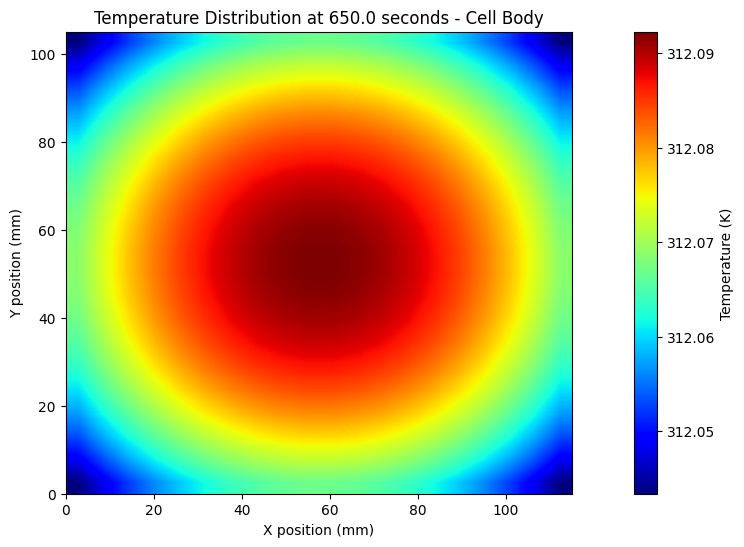

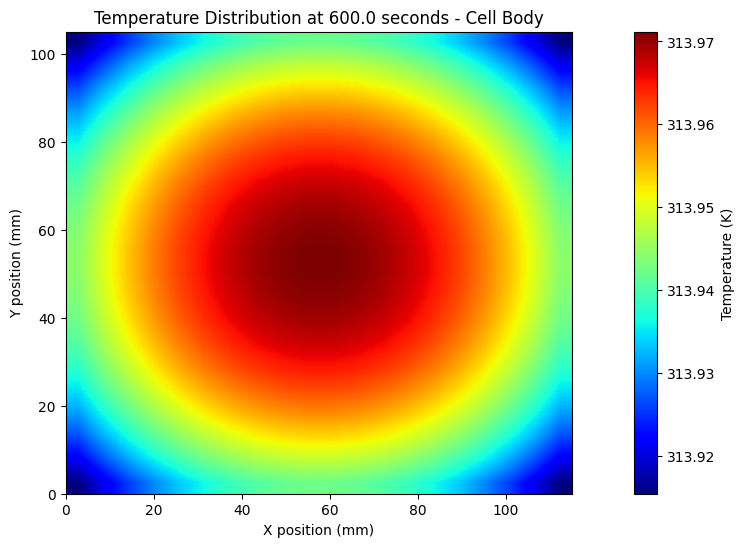

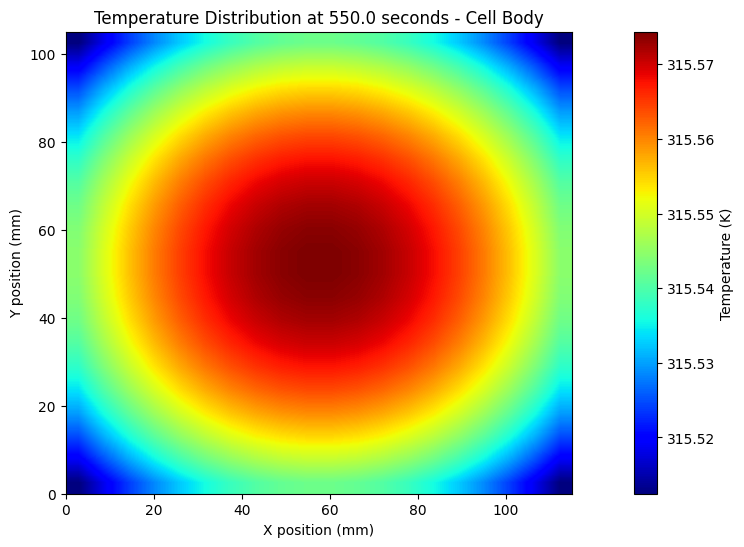

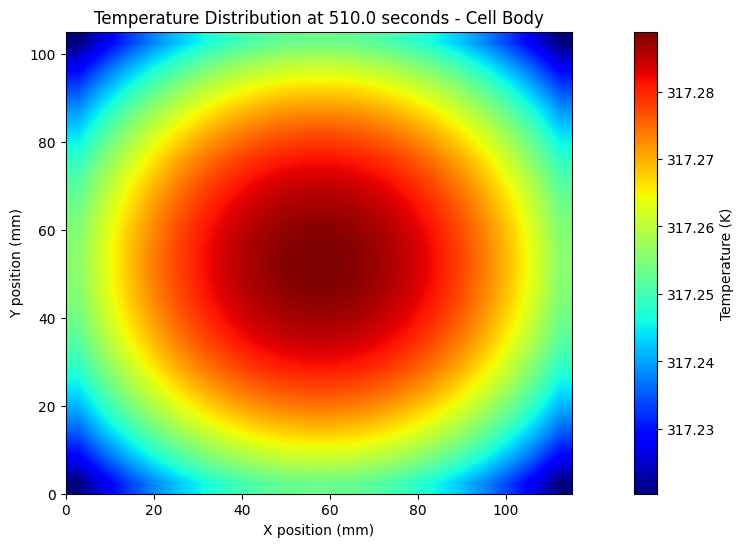

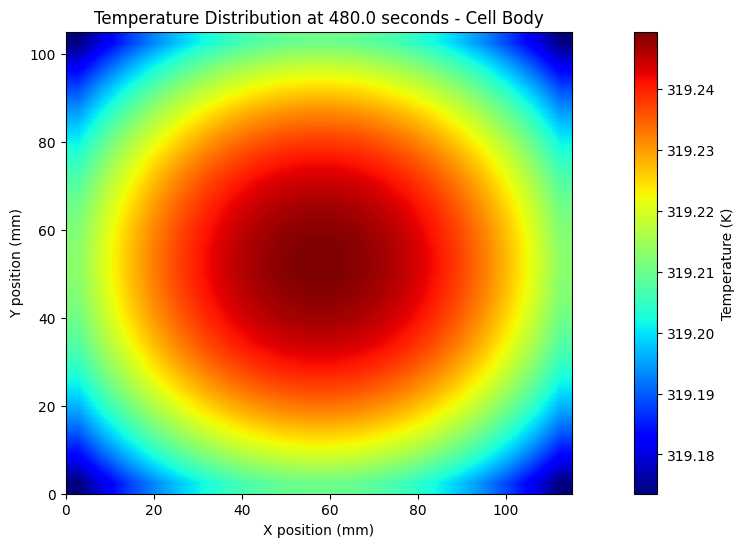

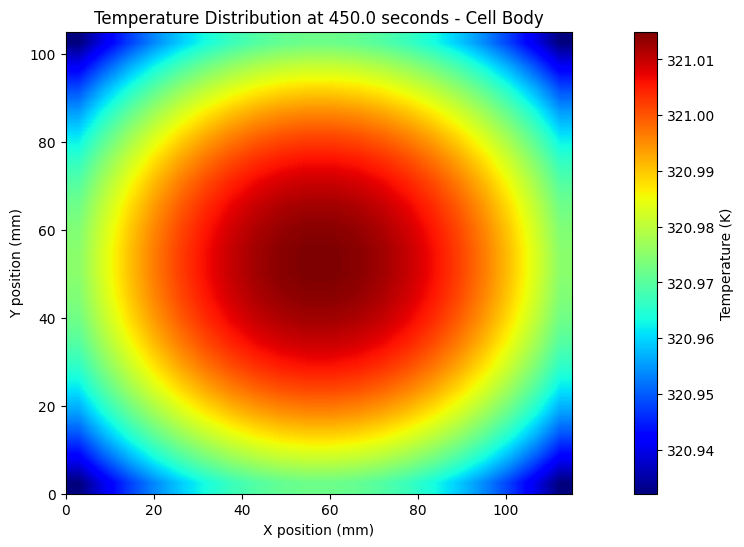

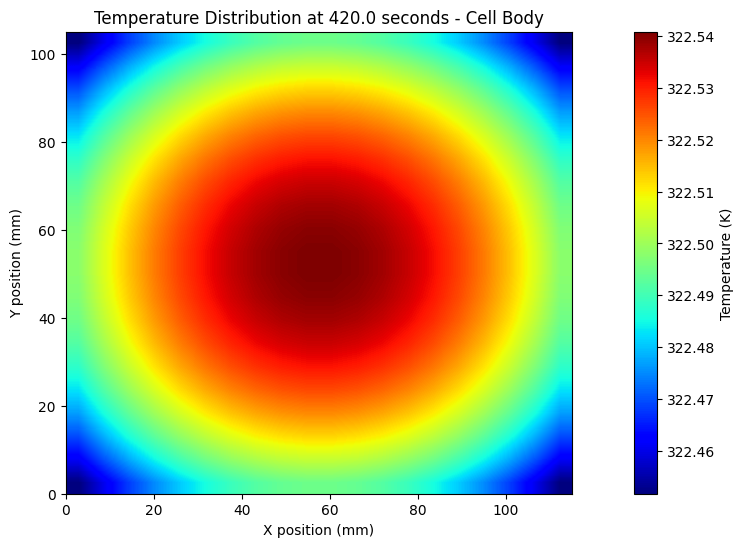

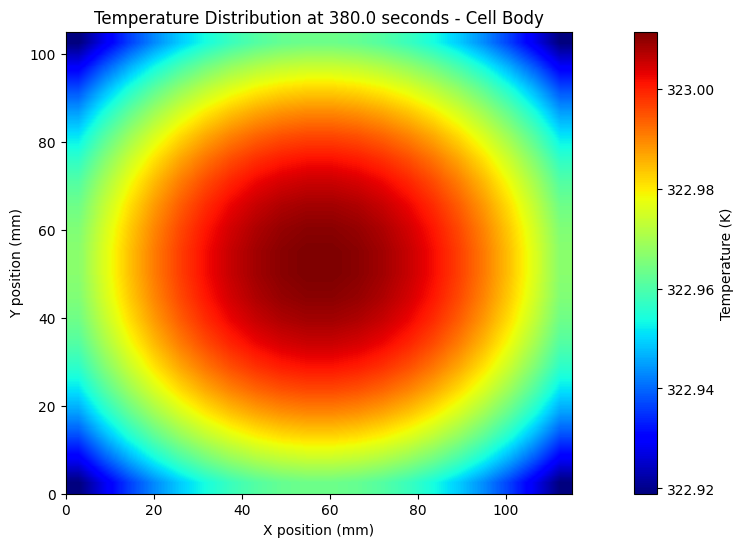

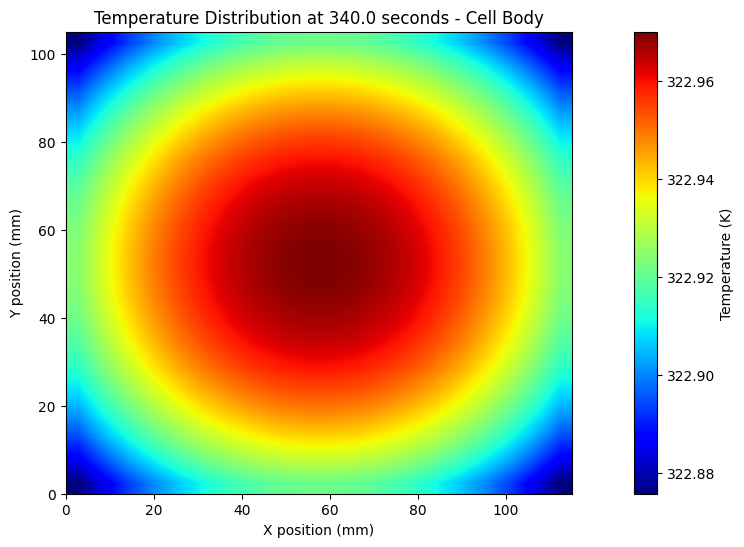

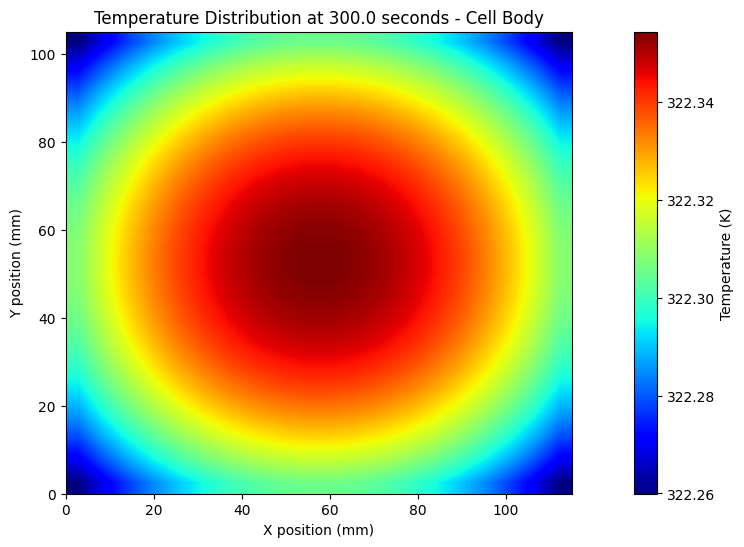

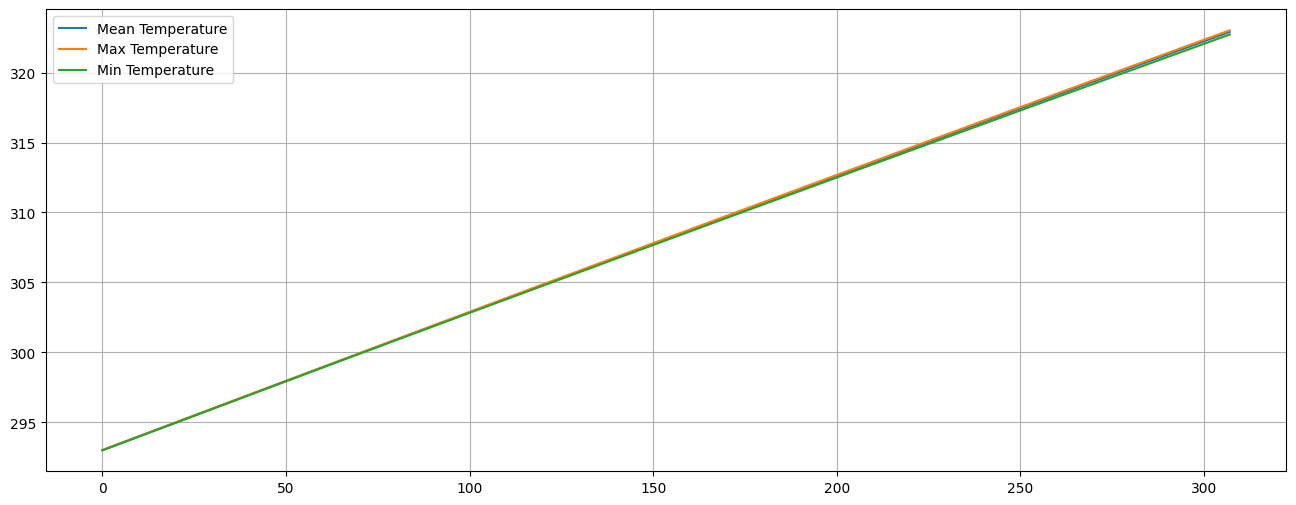

In [5]:
# Check for the input file. If NA, raise exception and exit
input_file = "./input.txt"
if not os.path.exists(input_file):
    print(f"Input file missing. Create input.txt with run cases: Ah, DCIR, C_rate")
    sys.exit(1)
fr = open(input_file, "r")
cases = fr.readlines()
fr.close()

# Prepare output dir
# Get program exec dir
# pwd = os.path.dirname(os.path.abspath(__file__))
pwd = os.getcwd()
curr_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f"{pwd}/output_fdm_laplace_{curr_timestamp}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for case in cases:
    case_params = case.split(",")
    main_func(case_params[0], case_params[1], case_params[2].replace("\n", ""), output_dir)